In [1]:
import spacy
import string
import pickle as pkl
import random
import io
import os
import nltk
from nltk import ngrams
import torch

from collections import Counter


In [2]:
cur_path = os.path.abspath('.')
train_path = cur_path + '\\aclImdb_v1\\aclImdb\\train'
test_path = cur_path + '\\aclImdb_v1\\aclImdb\\test'
mapper = cur_path + '\\mapped'

In [3]:
train_pos = []
train_neg = []
test_pos = []
test_neg = []

In [4]:
def file_reader(dataset, directory):
    for dirName, subdirList, fileList in os.walk(directory):
        for file in fileList:
            f = open(dirName + '\\'+ file, 'r', encoding = "utf-8")
            try:
                dataset.append(''.join(f.readlines()))
            except:
                print(file)
            f.close()

In [5]:
file_reader(train_pos, train_path + '\\pos')
file_reader(train_neg, train_path + '\\neg')
file_reader(test_pos, test_path + '\\pos')
file_reader(test_neg, test_path + '\\neg')

In [6]:
print(len(train_pos),len(train_neg),len(test_pos),len(test_neg))

12500 12500 12500 12500


In [6]:
all_train = train_pos[:10000] + train_neg[:10000]
all_train_tgt = [1] * 10000 + [0] * 10000
all_val = train_pos[10000:] + train_neg[10000:]
all_val_tgt = [1] * 2500 + [0] * 2500
all_test = test_pos[:] + test_neg[:]
all_test_tgt = [1] * 12500 + [0] * 12500

In [7]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

In [8]:

def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]

def tokenize_dataset_ngram(dataset, n):
    token_dataset = []
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_tokens = []

    for sample in tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=4):
        tokens = [token for token in ngrams(lower_case_remove_punc(sample), n)]
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens


# def tokenize(sentence):
#     tokens = tokenizer(sentence)
#     return [token.text.lower() for token in tokens if (token.text not in punctuations)]
# def tokenize_dataset_ngram(dataset, n):
#     token_dataset = []
#     all_tokens = set()
    
#     for sample in dataset:
#         tokens = [token for token in ngrams(tokenize(sample), n)]
#         token_dataset.append(tokens)
#         all_tokens.update(set(tokens))

#     return token_dataset, all_tokens

In [59]:
train_tknzed_3gram, all_train_tks_3gram = tokenize_dataset_ngram(all_train, 3)
val_tknzed_3gram, _ = tokenize_dataset_ngram(all_val, 3)
test_tknzed_3gram, _ = tokenize_dataset_ngram(all_test, 3)

In [13]:
train_tknzed_1gram, all_train_tks_1gram = tokenize_dataset_ngram(all_train, 1)
val_tknzed_1gram, _ = tokenize_dataset_ngram(all_val, 1)
test_tknzed_1gram, _ = tokenize_dataset_ngram(all_test, 1)

train_tknzed_2gram, all_train_tks_2gram = tokenize_dataset_ngram(all_train, 2)
val_tknzed_2gram, _ = tokenize_dataset_ngram(all_val, 2)
test_tknzed_2gram, _ = tokenize_dataset_ngram(all_test, 2)

train_tknzed_3gram, all_train_tks_3gram = tokenize_dataset_ngram(all_train, 3)
val_tknzed_3gram, _ = tokenize_dataset_ngram(all_val, 3)
test_tknzed_3gram, _ = tokenize_dataset_ngram(all_test, 3)

train_tknzed_4gram, all_train_tks_4gram = tokenize_dataset_ngram(all_train, 4)
val_tknzed_4gram, _ = tokenize_dataset_ngram(all_val, 4)
test_tknzed_4gram, _ = tokenize_dataset_ngram(all_test, 4)

In [ ]:
train_tknzed_1gram_punc, all_train_tks_1gram_punc = tokenize_dataset_ngram_withPunc(all_train, 1)
val_tknzed_1gram_punc, _ = tokenize_dataset_ngram_withPunc(all_val, 1)
test_tknzed_1gram_punc, _ = tokenize_dataset_ngram_withPunc(all_test, 1)

train_tknzed_1gram_long, all_train_tks_1gram_long = tokenize_dataset_ngram_withLong(all_train, 1)
val_tknzed_1gram_long, _ = tokenize_dataset_ngram_withLong(all_val, 1)
test_tknzed_1gram_long, _ = tokenize_dataset_ngram_withLong(all_test, 1)

In [ ]:
print(len(all_train_tks_1gram))

In [9]:
def pkl_dumper(objct, file_name):
    with open(file_name, 'wb+') as f:
        pkl.dump(objct, f, protocol=None)

def pkl_loader(file_name):
    with open(file_name, 'rb') as f:
        objct = pkl.load(f, encoding = 'bytes')
    return(objct)

In [ ]:
all_train_tks_3gram = pkl_loader('the_3grm_tokens.p')
train_tknzed_3gram = pkl_loader('the_3grm_tknzd_train.p')
val_tknzed_3gram = pkl_loader('the_3grm_tknzd_val.p')
test_tknzed_3gram = pkl_loader('the_3grm_tknzd_tst.p')

pkl_dumper(all_train_tks_3gram, 'the_3grm_tokens.p')
pkl_dumper(train_tknzed_3gram, 'the_3grm_tknzd_train.p')
pkl_dumper(val_tknzed_3gram, 'the_3grm_tknzd_val.p')
pkl_dumper(test_tknzed_3gram, 'the_3grm_tknzd_tst.p')

In [ ]:
# save index 0 for unk and 1 for pad
def build_vocab(all_tokens, max_vocab_size = 100000, PAD_IDX = 0, UNK_IDX = 1):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    #vocab, count
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    #add <pad>, <unk> to vocabulary
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [ ]:
token2id_1g, id2token_1g = build_vocab(all_train_tks_1gram)
token2id_2g, id2token_2g = build_vocab(all_train_tks_2gram)
token2id_3g, id2token_3g = build_vocab(all_train_tks_3gram)
token2id_4g, id2token_4g = build_vocab(all_train_tks_4gram)
token2id_1g_punc, id2token_1g_punc = build_vocab(all_train_tks_1gram_punc)
token2id_1g_long, id2token_1g_long = build_vocab(all_train_tks_1gram_long)

In [98]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {}; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 91384; token ('such', 'as', 'pet')
Token ('such', 'as', 'pet'); token id 91384


In [10]:
# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        #index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        index_list = [token2id.get(token, UNK_IDX) for token in tokens]
        indices_data.append(index_list)
    return indices_data

def index2token_dataset(indices_data, id2token):
    tokens_data = []
    for indices in indices_data:
        #index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        token_list = [id2token[index] for index in indices]
        tokens_data.append(token_list)
    return tokens_data


In [100]:
train_data_indices = token2index_dataset(train_tknzed_3gram)
val_data_indices = token2index_dataset(val_tknzed_3gram)
test_data_indices = token2index_dataset(test_tknzed_3gram)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [ ]:
train_data_indices_2g = token2index_dataset(train_tknzed_2gram, token2id_2g)
val_data_indices_2g = token2index_dataset(val_tknzed_2gram, token2id_2g)
test_data_indices_2g = token2index_dataset(test_tknzed_2gram, token2id_2g)

train_data_indices_3g = token2index_dataset(train_tknzed_3gram, token2id_3g)
val_data_indices_3g = token2index_dataset(val_tknzed_3gram, token2id_3g)
test_data_indices_3g = token2index_dataset(test_tknzed_3gram, token2id_3g)

train_data_indices_4g = token2index_dataset(train_tknzed_4gram, token2id_4g)
val_data_indices_4g = token2index_dataset(val_tknzed_4gram, token2id_4g)
test_data_indices_4g = token2index_dataset(test_tknzed_4gram, token2id_4g)

train_data_indices_1g_punc = token2index_dataset(train_tknzed_1gram_punc, token2id_1g_punc)
val_data_indices_1g_punc = token2index_dataset(val_tknzed_1gram_punc, token2id_1g_punc)
test_data_indices_1g_punc = token2index_dataset(test_tknzed_1gram_punc, token2id_1g_punc)

train_data_indices_1g_long = token2index_dataset(train_tknzed_1gram_long, token2id_1g_long)
val_data_indices_1g_long = token2index_dataset(val_tknzed_1gram_long, token2id_1g_long)
test_data_indices_1g_long = token2index_dataset(test_tknzed_1gram_long, token2id_1g_long)


In [88]:
token2id.get(('time', 'favorite', 'horror'))

985

In [12]:
id2token_1g = pkl_loader(mapper + '\\id2token_1g.p')
token2id_1g = pkl_loader(mapper + '\\token2id_1g.p')
test_data_indices_1g = pkl_loader(mapper + '\\test_data_indices_1g.p')
train_data_indices_1g = pkl_loader(mapper + '\\train_data_indices_1g.p')
val_data_indices_1g = pkl_loader(mapper + '\\val_data_indices_1g.p')

In [13]:
id2token_2g = pkl_loader(mapper + '\\id2token_2g.p')
token2id_2g = pkl_loader(mapper + '\\token2id_2g.p')
test_data_indices_2g = pkl_loader(mapper + '\\test_data_indices_2g.p')
train_data_indices_2g = pkl_loader(mapper + '\\train_data_indices_2g.p')
val_data_indices_2g = pkl_loader(mapper + '\\val_data_indices_2g.p')

id2token_3g = pkl_loader(mapper + '\\id2token_3g.p')
token2id_3g = pkl_loader(mapper + '\\token2id_3g.p')
test_data_indices_3g = pkl_loader(mapper + '\\test_data_indices_3g.p')
train_data_indices_3g = pkl_loader(mapper + '\\train_data_indices_3g.p')
val_data_indices_3g = pkl_loader(mapper + '\\val_data_indices_3g.p')

id2token_4g = pkl_loader(mapper + '\\id2token_4g.p')
token2id_4g = pkl_loader(mapper + '\\token2id_4g.p')
test_data_indices_4g = pkl_loader(mapper + '\\test_data_indices_4g.p')
train_data_indices_4g = pkl_loader(mapper + '\\train_data_indices_4g.p')
val_data_indices_4g = pkl_loader(mapper + '\\val_data_indices_4g.p')

In [14]:
id2token_Punc = pkl_loader(mapper + '\\dif_token\\id2token_1g_punc.p')
token2id_Punc = pkl_loader(mapper + '\\dif_token\\token2id_1g_punc.p')
test_data_indices_Punc = pkl_loader(mapper + '\\dif_token\\test_data_indices_1g_punc.p')
train_data_indices_Punc = pkl_loader(mapper + '\\dif_token\\train_data_indices_1g_punc.p')
val_data_indices_Punc = pkl_loader(mapper + '\\dif_token\\val_data_indices_1g_punc.p')

id2token_Long = pkl_loader(mapper + '\\dif_token\\id2token_1g_long.p')
token2id_Long = pkl_loader(mapper + '\\dif_token\\token2id_1g_long.p')
test_data_indices_Long = pkl_loader(mapper + '\\dif_token\\test_data_indices_1g_long.p')
train_data_indices_Long = pkl_loader(mapper + '\\dif_token\\train_data_indices_1g_long.p')
val_data_indices_Long = pkl_loader(mapper + '\\dif_token\\val_data_indices_1g_long.p')

In [15]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class !!!!!!inherits torch.utils.data.Dataset!!!!!!
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically !!!pads!!! the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices_1g, all_train_tgt)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_1g, all_val_tgt)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices_1g, all_test_tgt)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

In [16]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        # super: call methods in parent class
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data.long())
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 400
model = BagOfWords(len(id2token_1g), emb_dim)

In [ ]:
train

In [29]:
learning_rate = 0.005
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


def adjust_learning_rate(optimizer, learning_rate, epoch):
    lr = learning_rate * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def grid_searcher(learning_rate, adj_lr, num_epochs, optmzr, id2token, emb_dim, acc_recorder, tester):
    model = BagOfWords(len(id2token), emb_dim)
    if optmzr == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optmzr == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        #adjust LR
        if adj_lr == True:
            adjust_learning_rate(optimizer, learning_rate, epoch)
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            #print(type(data_batch), type(length_batch))
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_loss.append(100.0-test_model(train_loader, model))
                # val_acc.append(test_model(val_loader, model))
                print('Epoch: [{}/{}], Step: [{}/{}], Train_Loss: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), train_loss[-1]))
        ##early termination
        # if val_acc[-1] < val_acc[-7] and val_acc[-2] < val_acc[-8]:
        # break
    if tester == 'former':
        acc_recorder['lr:'+str(learning_rate)+' adj_lr:'+str(adj_lr)+' num_epochs:'+str(num_epochs)] = train_loss
    if tester == 'later':
        acc_recorder['optimizer:'+str(optmzr)+' len_vocabulary:'+str(len(id2token))+' embedding_dim:'+str(emb_dim)] = train_loss
    model.zero_grad()
    del(model)

In [30]:
acc_recorder = {}
for lr in [0.001, 0.005, 0.01]:
    for adj_lr in [True, False]:
        grid_searcher(lr, adj_lr, 5, 'Adam', id2token_1g, 400, acc_recorder, 'former')

Epoch: [1/5], Step: [101/625], Train_Loss: 38.105
Epoch: [1/5], Step: [201/625], Train_Loss: 31.75
Epoch: [1/5], Step: [301/625], Train_Loss: 27.590000000000003
Epoch: [1/5], Step: [401/625], Train_Loss: 22.78
Epoch: [1/5], Step: [501/625], Train_Loss: 20.245000000000005
Epoch: [1/5], Step: [601/625], Train_Loss: 17.295
Epoch: [2/5], Step: [101/625], Train_Loss: 15.430000000000007
Epoch: [2/5], Step: [201/625], Train_Loss: 14.185000000000002
Epoch: [2/5], Step: [301/625], Train_Loss: 13.329999999999998
Epoch: [2/5], Step: [401/625], Train_Loss: 11.944999999999993
Epoch: [2/5], Step: [501/625], Train_Loss: 11.334999999999994
Epoch: [2/5], Step: [601/625], Train_Loss: 10.995000000000005
Epoch: [3/5], Step: [101/625], Train_Loss: 10.209999999999994
Epoch: [3/5], Step: [201/625], Train_Loss: 9.700000000000003
Epoch: [3/5], Step: [301/625], Train_Loss: 9.355000000000004
Epoch: [3/5], Step: [401/625], Train_Loss: 8.799999999999997
Epoch: [3/5], Step: [501/625], Train_Loss: 9.075000000000003


In [31]:
list(acc_recorder.keys())

['lr:0.001 adj_lr:True num_epochs:5',
 'lr:0.001 adj_lr:False num_epochs:5',
 'lr:0.005 adj_lr:True num_epochs:5',
 'lr:0.005 adj_lr:False num_epochs:5',
 'lr:0.01 adj_lr:True num_epochs:5',
 'lr:0.01 adj_lr:False num_epochs:5']

In [32]:
acc_recorder_all = []
acc_recorder_2 = {}
for epcs in [5, 10, 15]:
    grid_searcher(0.001, True, epcs, 'Adam', id2token_1g, 400, acc_recorder_2, 'former')
        
pkl_dumper(acc_recorder_2, 'result/result_epoches.p')

acc_recorder_all = []
acc_recorder_3 = {}
for optmz in ['Adam', 'SGD']:
    grid_searcher(0.001, True, 5, optmz, id2token_1g, 400, acc_recorder_3, 'later')
        
pkl_dumper(acc_recorder_3, 'result/result_optimizer.p')

acc_recorder_all = []
acc_recorder_4 = {}
for emb_dim in [100, 200, 400]:
    grid_searcher(0.001, True, 5, 'Adam', id2token_1g, emb_dim, acc_recorder_4, 'later')
    
pkl_dumper(acc_recorder_4, 'result/result_emb_dim.p')
    
acc_recorder_all = []
acc_recorder = {}
for tknzr in [id2token_1g_10k, id2token_1g_100k, id2token_1g_1000k]:
    grid_searcher(0.005, True, 5, 'Adam', tknzr, 400, acc_recorder, 'later')
pkl_dumper(acc_recorder, 'result/result_vocab_len.p')


Epoch: [1/5], Step: [101/625], Train_Loss: 33.075
Epoch: [1/5], Step: [201/625], Train_Loss: 32.435
Epoch: [1/5], Step: [301/625], Train_Loss: 25.299999999999997
Epoch: [1/5], Step: [401/625], Train_Loss: 21.174999999999997
Epoch: [1/5], Step: [501/625], Train_Loss: 18.965000000000003
Epoch: [1/5], Step: [601/625], Train_Loss: 16.989999999999995
Epoch: [2/5], Step: [101/625], Train_Loss: 15.129999999999995
Epoch: [2/5], Step: [201/625], Train_Loss: 14.295000000000002
Epoch: [2/5], Step: [301/625], Train_Loss: 13.409999999999997
Epoch: [2/5], Step: [401/625], Train_Loss: 12.579999999999998
Epoch: [2/5], Step: [501/625], Train_Loss: 11.730000000000004
Epoch: [2/5], Step: [601/625], Train_Loss: 11.015
Epoch: [3/5], Step: [101/625], Train_Loss: 10.924999999999997
Epoch: [3/5], Step: [201/625], Train_Loss: 10.004999999999995
Epoch: [3/5], Step: [301/625], Train_Loss: 9.635000000000005
Epoch: [3/5], Step: [401/625], Train_Loss: 9.194999999999993
Epoch: [3/5], Step: [501/625], Train_Loss: 8.7

Epoch: [1/5], Step: [501/625], Train_Loss: 23.215000000000003
Epoch: [1/5], Step: [601/625], Train_Loss: 20.819999999999993
Epoch: [2/5], Step: [101/625], Train_Loss: 18.515
Epoch: [2/5], Step: [201/625], Train_Loss: 18.019999999999996
Epoch: [2/5], Step: [301/625], Train_Loss: 15.534999999999997
Epoch: [2/5], Step: [401/625], Train_Loss: 15.665000000000006
Epoch: [2/5], Step: [501/625], Train_Loss: 13.655000000000001
Epoch: [2/5], Step: [601/625], Train_Loss: 13.079999999999998
Epoch: [3/5], Step: [101/625], Train_Loss: 12.814999999999998
Epoch: [3/5], Step: [201/625], Train_Loss: 11.840000000000003
Epoch: [3/5], Step: [301/625], Train_Loss: 11.474999999999994
Epoch: [3/5], Step: [401/625], Train_Loss: 10.900000000000006
Epoch: [3/5], Step: [501/625], Train_Loss: 10.415000000000006
Epoch: [3/5], Step: [601/625], Train_Loss: 10.099999999999994
Epoch: [4/5], Step: [101/625], Train_Loss: 9.735
Epoch: [4/5], Step: [201/625], Train_Loss: 9.450000000000003
Epoch: [4/5], Step: [301/625], Tra

In [33]:
train_dataset = NewsGroupDataset(train_data_indices_2g, all_train_tgt)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_2g, all_val_tgt)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices_2g, all_test_tgt)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

acc_recorder_ngram = []
acc_recorder_ngram.append({})
grid_searcher(0.001, True, 5, 'Adam', id2token_2g, 400, acc_recorder_ngram[0], 'former')

train_dataset = NewsGroupDataset(train_data_indices_3g, all_train_tgt)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_3g, all_val_tgt)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices_3g, all_test_tgt)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

acc_recorder_ngram.append({})
grid_searcher(0.001, True, 5, 'Adam', id2token_3g, 400, acc_recorder_ngram[1], 'former')

train_dataset = NewsGroupDataset(train_data_indices_4g, all_train_tgt)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_4g, all_val_tgt)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices_4g, all_test_tgt)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

acc_recorder_ngram.append({})
grid_searcher(0.001, True, 5, 'Adam', id2token_4g, 400, acc_recorder_ngram[2], 'former')

pkl_dumper(acc_recorder_ngram, 'result/result_n_gram.p')

Epoch: [1/5], Step: [101/625], Train_Loss: 49.9
Epoch: [1/5], Step: [201/625], Train_Loss: 49.935
Epoch: [1/5], Step: [301/625], Train_Loss: 28.924999999999997
Epoch: [1/5], Step: [401/625], Train_Loss: 26.845
Epoch: [1/5], Step: [501/625], Train_Loss: 20.730000000000004
Epoch: [1/5], Step: [601/625], Train_Loss: 19.129999999999995
Epoch: [2/5], Step: [101/625], Train_Loss: 16.564999999999998
Epoch: [2/5], Step: [201/625], Train_Loss: 19.28
Epoch: [2/5], Step: [301/625], Train_Loss: 14.105000000000004
Epoch: [2/5], Step: [401/625], Train_Loss: 13.715000000000003
Epoch: [2/5], Step: [501/625], Train_Loss: 13.094999999999999
Epoch: [2/5], Step: [601/625], Train_Loss: 12.295000000000002
Epoch: [3/5], Step: [101/625], Train_Loss: 11.790000000000006
Epoch: [3/5], Step: [201/625], Train_Loss: 11.680000000000007
Epoch: [3/5], Step: [301/625], Train_Loss: 11.269999999999996
Epoch: [3/5], Step: [401/625], Train_Loss: 11.439999999999998
Epoch: [3/5], Step: [501/625], Train_Loss: 10.375
Epoch: [3

In [34]:
acc_recorder_dif_tknzt = []

train_dataset = NewsGroupDataset(train_data_indices_Punc, all_train_tgt)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_Punc, all_val_tgt)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices_Punc, all_test_tgt)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

acc_recorder_dif_tknzt.append({})
grid_searcher(0.001, True, 5, 'Adam', id2token_Punc, 400, acc_recorder_dif_tknzt[0], 'former')

train_dataset = NewsGroupDataset(train_data_indices_Long, all_train_tgt)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_Long, all_val_tgt)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices_Long, all_test_tgt)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

acc_recorder_dif_tknzt.append({})
grid_searcher(0.001, True, 5, 'Adam', id2token_Long, 400, acc_recorder_dif_tknzt[1], 'former')

pkl_dumper(acc_recorder_ngram, 'result/result_dif_tknzt.p')

Epoch: [1/5], Step: [101/625], Train_Loss: 34.44499999999999
Epoch: [1/5], Step: [201/625], Train_Loss: 28.599999999999994
Epoch: [1/5], Step: [301/625], Train_Loss: 24.275000000000006
Epoch: [1/5], Step: [401/625], Train_Loss: 21.430000000000007
Epoch: [1/5], Step: [501/625], Train_Loss: 19.125
Epoch: [1/5], Step: [601/625], Train_Loss: 17.049999999999997
Epoch: [2/5], Step: [101/625], Train_Loss: 16.599999999999994
Epoch: [2/5], Step: [201/625], Train_Loss: 14.790000000000006
Epoch: [2/5], Step: [301/625], Train_Loss: 13.370000000000005
Epoch: [2/5], Step: [401/625], Train_Loss: 12.394999999999996
Epoch: [2/5], Step: [501/625], Train_Loss: 11.985
Epoch: [2/5], Step: [601/625], Train_Loss: 11.010000000000005
Epoch: [3/5], Step: [101/625], Train_Loss: 10.349999999999994
Epoch: [3/5], Step: [201/625], Train_Loss: 9.969999999999999
Epoch: [3/5], Step: [301/625], Train_Loss: 9.454999999999998
Epoch: [3/5], Step: [401/625], Train_Loss: 8.959999999999994
Epoch: [3/5], Step: [501/625], Train

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

## HyperParameter Tuning

#### Learning Rate and Annealing

In [36]:
acc_recorder

{'lr:0.001 adj_lr:False num_epochs:5': [39.945,
  29.655,
  28.540000000000006,
  25.159999999999997,
  19.595,
  18.099999999999994,
  15.084999999999994,
  14.655000000000001,
  13.180000000000007,
  12.060000000000002,
  11.625,
  11.814999999999998,
  10.989999999999995,
  9.730000000000004,
  9.489999999999995,
  9.060000000000002,
  8.474999999999994,
  8.924999999999997,
  7.805000000000007,
  7.6200000000000045,
  7.334999999999994,
  7.269999999999996,
  6.894999999999996,
  7.215000000000003,
  6.450000000000003,
  6.25,
  6.204999999999998,
  5.935000000000002,
  5.650000000000006,
  5.569999999999993],
 'lr:0.001 adj_lr:True num_epochs:5': [38.105,
  31.75,
  27.590000000000003,
  22.78,
  20.245000000000005,
  17.295,
  15.430000000000007,
  14.185000000000002,
  13.329999999999998,
  11.944999999999993,
  11.334999999999994,
  10.995000000000005,
  10.209999999999994,
  9.700000000000003,
  9.355000000000004,
  8.799999999999997,
  9.075000000000003,
  8.185000000000002,


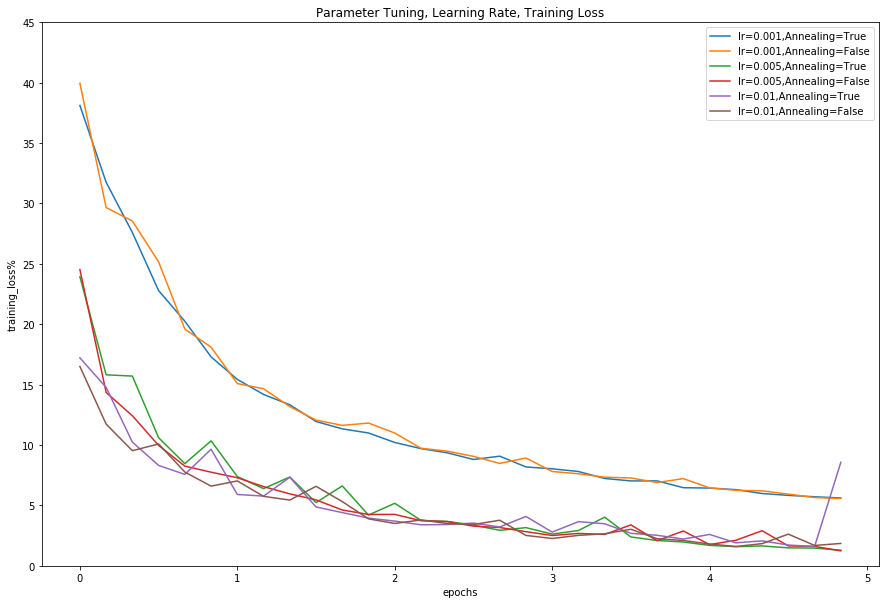

In [44]:
#plot_step = .001
xpts = np.arange(0 , 5, 1/6).reshape(-1,1)
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for lr in ['0.001','0.005','0.01']:
    for anlr in ['True', 'False']:
        y = acc_recorder[list(acc_recorder.keys())[i]]
        label = "lr="+str(lr)+",Annealing="+str(anlr)
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1

ax.legend(loc = 'best')
plt.title('Parameter Tuning, Learning Rate, Training Loss')
plt.xlabel('epochs')
plt.ylabel('training_loss%')
plt.ylim(0,45)
plt.show()

#### Number of Epoches

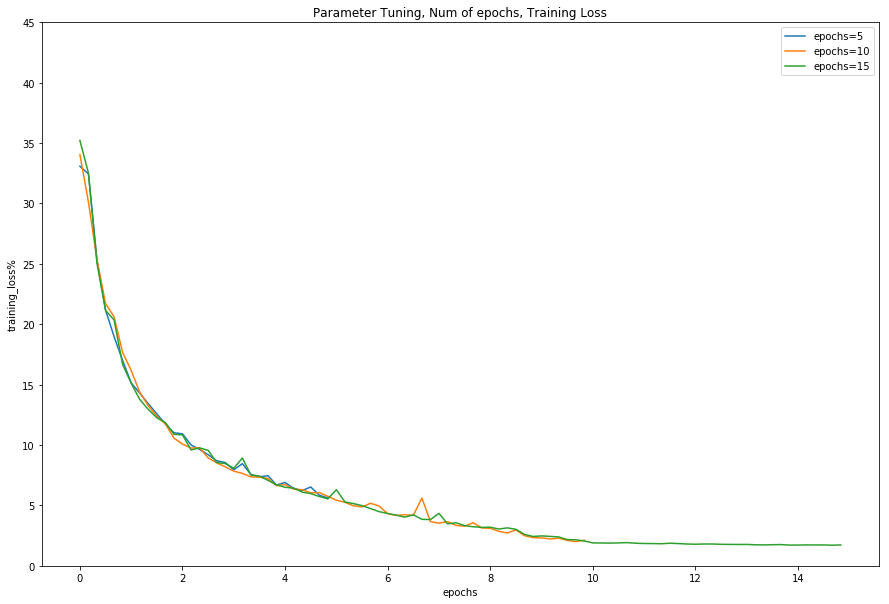

In [45]:
#plot_step = .001
xpts = np.arange(0 , 15, 1/6).reshape(-1,1)
fig,ax2=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for epochs in ['5','10','15']:
    y = acc_recorder_2[list(acc_recorder_2.keys())[i]]
    label = "epochs="+str(epochs)
    lines[label],=ax2.plot(xpts[:len(y)], y, label=label)
    i += 1

ax2.legend(loc = 'best')
plt.title('Parameter Tuning, Num of epochs, Training Loss')
plt.xlabel('epochs')
plt.ylabel('training_loss%')
plt.ylim(0,45)
plt.show()

#### Optimization Method

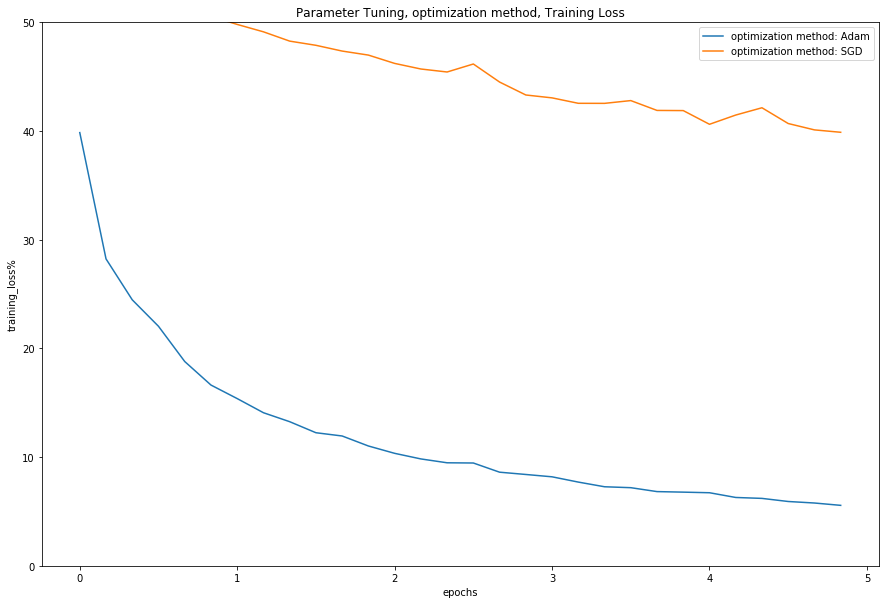

In [47]:
#plot_step = .001
xpts = np.arange(0 , 5, 1/6).reshape(-1,1)
fig,ax3=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for optmz in ['Adam','SGD']:
    y = acc_recorder_3[list(acc_recorder_3.keys())[i]]
    label = "optimization method: "+str(optmz)
    lines[label],=ax3.plot(xpts, y, label=label)
    i += 1

ax3.legend(loc = 'best')
plt.title('Parameter Tuning, optimization method, Training Loss')
plt.xlabel('epochs')
plt.ylabel('training_loss%')
plt.ylim(0,50)
plt.show()

#### Embedding Dimension

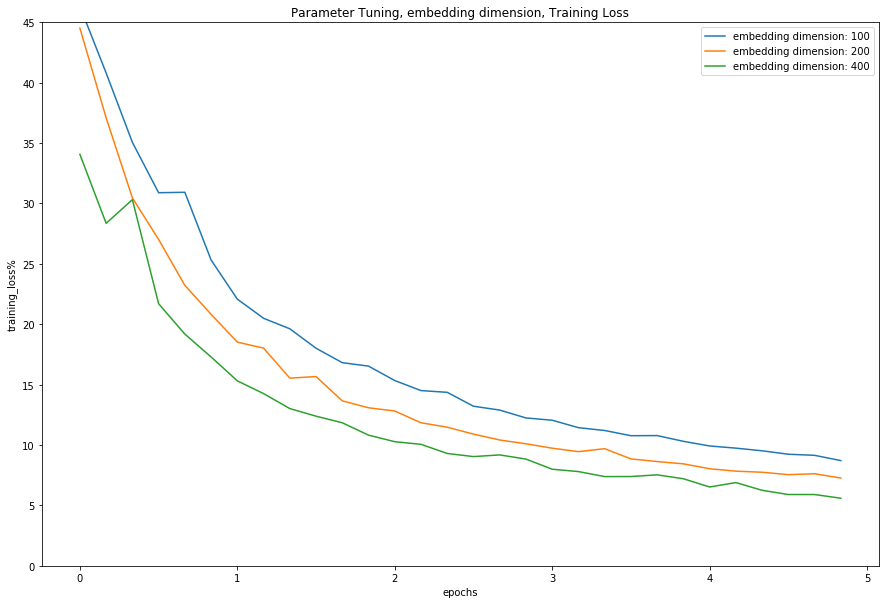

In [48]:
#plot_step = .001
xpts = np.arange(0 , 5, 1/6).reshape(-1,1)
fig,ax4=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for emb_dim in ['100', '200', '400']:
    y = acc_recorder_4[list(acc_recorder_4.keys())[i]]
    label = "embedding dimension: "+str(emb_dim)
    lines[label],=ax4.plot(xpts, y, label=label)
    i += 1

ax4.legend(loc = 'best')
plt.title('Parameter Tuning, embedding dimension, Training Loss')
plt.xlabel('epochs')
plt.ylabel('training_loss%')
plt.ylim(0,45)
plt.show()

#### Vocabulary Size

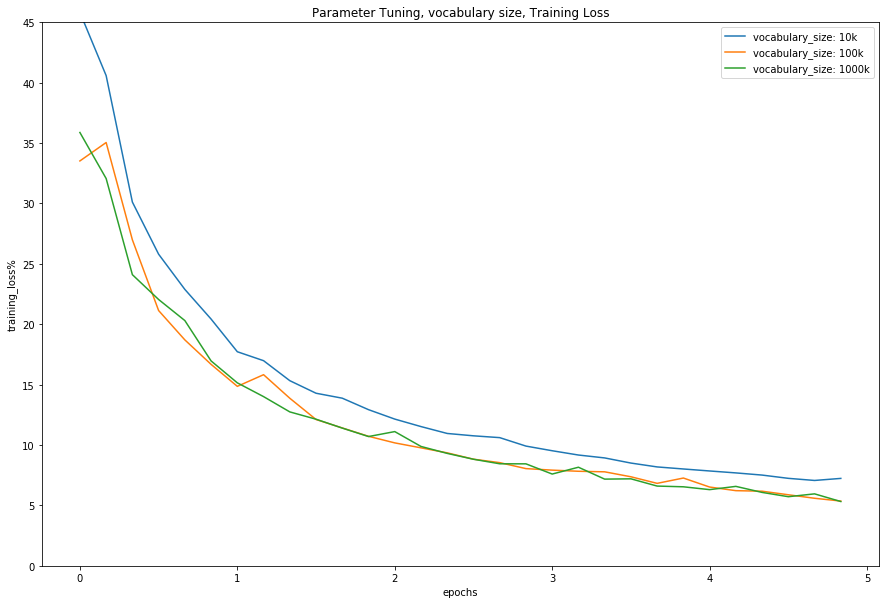

In [49]:
#plot_step = .001
xpts = np.arange(0 , 5, 1/6).reshape(-1,1)
fig,ax5=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for vocab_size in ['10k', '100k', '1000k']:
    y = acc_recorder_5[list(acc_recorder_5.keys())[i]]
    label = "vocabulary_size: "+str(vocab_size)
    lines[label],=ax5.plot(xpts, y, label=label)
    i += 1

ax5.legend(loc = 'best')
plt.title('Parameter Tuning, vocabulary size, Training Loss')
plt.xlabel('epochs')
plt.ylabel('training_loss%')
plt.ylim(0,45)
plt.show()

#### Number of N for N-grams

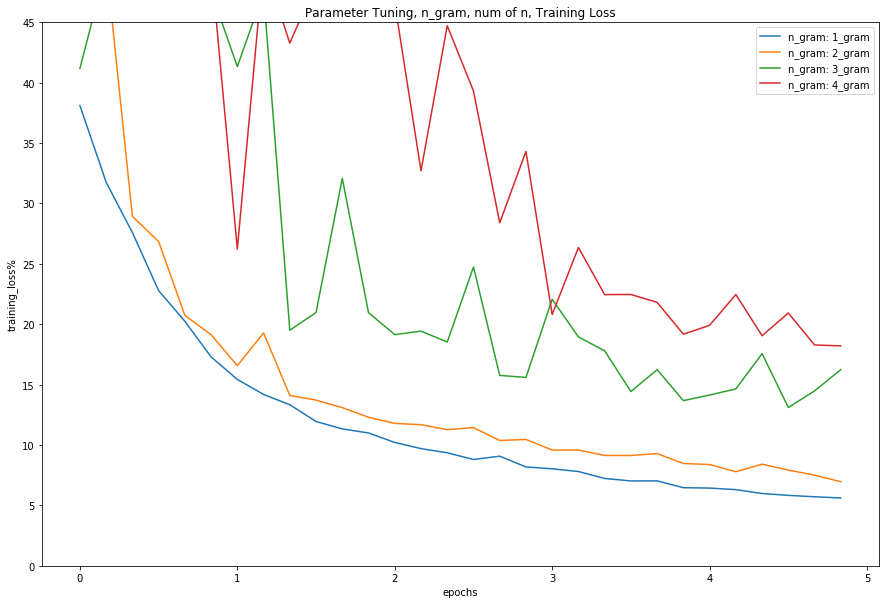

In [50]:
#plot_step = .001
xpts = np.arange(0 , 5, 1/6).reshape(-1,1)
fig,ax6=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for n_gram in ['1_gram', '2_gram', '3_gram', '4_gram']:
    if n_gram == '1_gram':
        y = acc_recorder[list(acc_recorder.keys())[0]]
    else:
        y = acc_recorder_ngram[i-1][list(acc_recorder_ngram[i-1].keys())[0]]
    label = "n_gram: "+str(n_gram)
    lines[label],=ax6.plot(xpts, y, label=label)
    i += 1

ax6.legend(loc = 'best')
plt.title('Parameter Tuning, n_gram, num of n, Training Loss')
plt.xlabel('epochs')
plt.ylabel('training_loss%')
plt.ylim(0,45)
plt.show()

#### Method of Tokenization, without punctuations, with punctuations, filter short words (shorter than 3 chars)

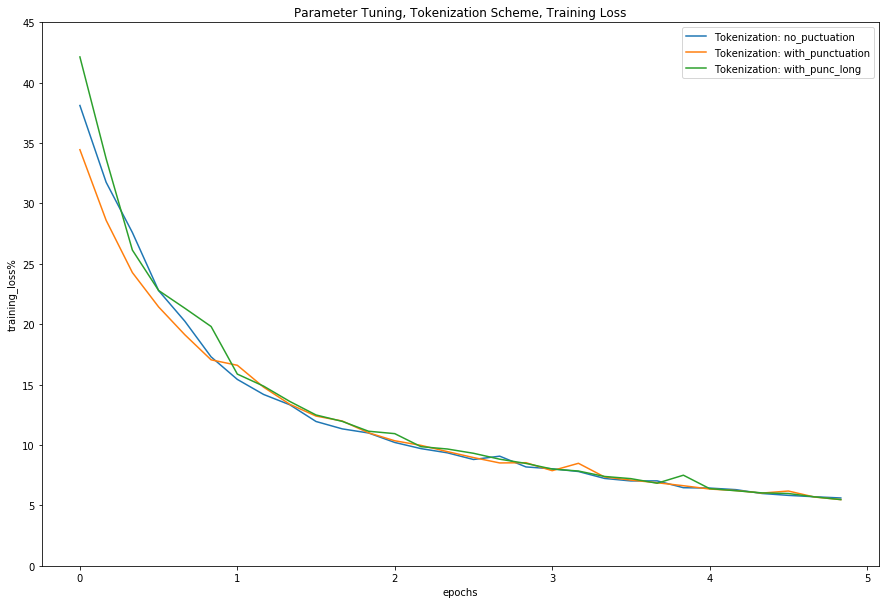

In [51]:
#plot_step = .001
xpts = np.arange(0 , 5, 1/6).reshape(-1,1)
fig,ax7=plt.subplots(figsize=(15,10))
lines=locals()
#lines['Ori data'],=ax.plot(x_train,y_train,'o')
#l2reg = 0.0001
i = 0
for tknzt in ['no_puctuation', 'with_punctuation', 'with_punc_long']:
    if tknzt == 'no_puctuation':
        y = acc_recorder[list(acc_recorder.keys())[0]]
    else:
        y = acc_recorder_dif_tknzt[i-1][list(acc_recorder_dif_tknzt[i-1].keys())[0]]
    label = "Tokenization: "+str(tknzt)
    lines[label],=ax7.plot(xpts, y, label=label)
    i += 1

ax7.legend(loc = 'best')
plt.title('Parameter Tuning, Tokenization Scheme, Training Loss')
plt.xlabel('epochs')
plt.ylabel('training_loss%')
plt.ylim(0,45)
plt.show()

#### Report Performance of Best Model with Test Set

In [130]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices_1g, all_train_tgt)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_1g, all_val_tgt)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices_1g, all_test_tgt)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

def test_reporter(learning_rate, adj_lr, num_epochs, optmzr, id2token, emb_dim, acc_recorder, tester):
    model = BagOfWords(len(id2token), emb_dim)
    if optmzr == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optmzr == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    val_acc = []
    for epoch in range(num_epochs):
        #adjust LR
        if adj_lr == True:
            adjust_learning_rate(optimizer, learning_rate, epoch)
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            #print(type(data_batch), type(length_batch))
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc.append(test_model(test_loader, model))
                # print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                #            epoch+1, num_epochs, i+1, len(train_loader), val_acc[-1]))
        ##early termination
        # if val_acc[-1] < val_acc[-7] and val_acc[-2] < val_acc[-8]:
        # break
    if tester == 'former':
        acc_recorder['lr:'+str(learning_rate)+' adj_lr:'+str(adj_lr)+' num_epochs:'+str(num_epochs)] = val_acc
    if tester == 'later':
        acc_recorder['optimizer:'+str(optmzr)+' len_vocabulary:'+str(len(id2token))+' embedding_dim:'+str(emb_dim)] = val_acc
    model.zero_grad()
    del(model)
    
test_result = {}
test_reporter(0.001, True, 5, 'Adam', id2token_1g, 400, test_result, 'former')
print('test accuracy is: {}'.format(test_result[list(test_result.keys())[0]][-1]))

test accuracy is: 87.556


In [112]:
def predictor(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    all_predicted = []
    all_label = []
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = [x.item() for x in outputs.max(1, keepdim=True)[1]]
        all_predicted += predicted
        all_label += [x.item() for x in labels]
        
        # total += labels.size(0)
        # correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (all_predicted, all_label)

In [ ]:
train_dataset = NewsGroupDataset(train_data_indices_1g, all_train_tgt)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

val_dataset = NewsGroupDataset(val_data_indices_1g, all_val_tgt)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

test_dataset = NewsGroupDataset(test_data_indices_1g, all_test_tgt)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

#### Get the prediction from validation set, print 5 wrong and 5 right predictions

In [137]:
pkl_dumper(model, 'best_model_BoW.p')
all_pred, all_lab = predictor(val_loader, model)

In [139]:
wrong_pred_recorder = []
right_pred_recorder = []
for i in range(1000, 4000):
    if all_pred[i] != all_lab[i]:
        wrong_pred_recorder.append((all_val[i], all_lab[i]))
    else:
        right_pred_recorder.append((all_val[i], all_lab[i]))

In [140]:
for i,cen in enumerate(wrong_pred_recorder):
    print(cen)
    if i > 5:
        break

('This is halfway to being a top movie. The opening section, which spoofs Hollywood "social message" films is absolutely brilliant. It is a riot from start to finish.<br /><br />The second section, which introduces us to the main characters of the story is really great too. We get a lot of great comic setups, top notch performances, and the dialog is really dynamic.<br /><br />(Spoiler warning!)<br /><br />The one think that really annoyed me about this film though is the ending, which I think contradicts everything that went before. My interpretation was that this film was taking the mickey out all the silly prejudices and innuendo of small town gossip and national tabloid sensationalism. I loved that the film was championing the cause that a person\'s sexuality is NOT determined by their hobbies, idiosyncrasies, fashion sense or whatever. And then the ending goes and re-enforces all the gossip and stereotypes that the movie successfully lampooned in the first place. It turns out ever

In [141]:
for i,cen in enumerate(right_pred_recorder):
    print(cen)
    if i > 5:
        break

("After reading the comment made about this movie, and currently watching it, I can understand how the person felt about it. The decisions made were after listening to common sense. When the movie came out, I had heard the information as to how it came about. The storyline was made from an actual event. During an award show, an actor, thanking the li'l people, attributed the award to a former school teacher, unexpectedly outing the person.<br /><br />Of course, many people come 'out' of the closet most every day. Each outing is different for each person. In real life, the outcome of any individual is gonna be different as well. And a willingness to accept who they are is the most important thing in life to reach personal happiness. For those around them, the joy and honest acceptance can make life much more fuller. For the movie, the outcome of how Howard is out'ed is a lot more comical than real life. And the acceptance of the community showed the others that Howard was himself and no